In [1]:
# all of my custom functions can be found in utils/util.py
from utils.util import *
from collections import OrderedDict

# Set the following paths:
    
    1. summarized_df_path - This should be a path pointing to the complex_mafaulda_1sec.csv file found on the G-drive
        Machine Learning/Nick/MAFAULDA resources/resources/data/complex_mafaulda_1sec.csv
    
    2. plot_path - This should be a path pointing to the "plots" directory on the G-drive
        Machine Learning/Nick/MAFAULDA resources/resources/window/plots/
    
    3. MAFAULDA_PATH
        the directory where raw MAFAULDA data is located. More specifically, my functions will look for the 
        directory that contains the "full" directory. 
        Example of MAFAULDA file structure: {MAFAULDA_PATH}/full/normal/12.288.csv

In [2]:
summarized_df_path = '~/Google Drive/Shared drives/Coastal Carolina Data Sharing (no CUI)/Machine Learning/Nick/MAFAULDA resources/resources/data/complex_mafaulda_1sec.csv'
plot_path = './plots/'
# the directory where raw MAFAULDA data is located. More specifically, my functions will look for the directory
# that contains the "full" directory. 
# Example of MAFAULDA file structure: {MAFAULDA_PATH}/full/normal/12.288.csv
MAFAULDA_PATH = '../data/'

# Read in summarized MaFaulDa data

In [3]:
df = pd.read_csv(summarized_df_path).drop('startPoint',axis=1)
df.head()

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,axialOverhang-F,...,microphone-Mean,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency,class,path
0,10.633214,0.004950,0.009842,0.156278,0.101619,0.122819,10.463767,-0.110942,-0.009464,0.020566,...,0.012263,0.022078,0.008598,0.021983,9.656114,1.898132,0.004390,61.00000,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
1,10.628957,0.194001,0.008607,0.162711,0.167297,0.163898,10.505807,0.407069,0.017773,0.023624,...,0.011990,0.021764,0.009035,0.021343,9.658679,2.001966,-0.006402,60.99878,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
2,10.624347,-0.220687,0.009522,0.159777,0.133762,0.045357,10.473719,-0.221713,-0.000486,0.010891,...,0.011806,0.021401,0.008802,0.020001,9.643273,1.864986,0.004954,60.99878,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
3,10.620357,-0.254865,0.009031,0.162775,0.093203,0.075060,10.451755,-0.086090,-0.012446,0.016143,...,0.012013,0.022151,0.010173,0.021473,9.649679,1.952311,-0.007070,60.99878,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
4,10.631042,-0.154502,0.008411,0.168113,0.088672,0.106329,10.447604,-0.386185,0.026383,0.015667,...,0.011881,0.022520,0.009568,0.022267,9.644393,1.889186,0.006114,60.99878,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv


# Create a dictionary that maps fault types to integer values
    - add a "mixed" class for when a window is hovering over two distinct fault types

In [4]:
# make our class dictionary
keys = list(np.unique(df['class']))
codes = [int(_) for _ in np.arange(0,len(keys))]
classDict = dict(zip(keys,codes))
classDict

{'horizontal-misalignment': 0,
 'imbalance': 1,
 'normal': 2,
 'overhang': 3,
 'underhang': 4,
 'vertical-misalignment': 5}

## create a new column that is the integer representation of class strings

In [5]:
df['CLASS'] = df['class']
df['class'] = df['class'].map(classDict)

# Train test split (80/20)

In [6]:
X = df.drop(columns=['class','path','CLASS'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=45,
                                                    stratify=None)

print(f'Length of train set: {len(X_train)}')
print(f'Length of test set: {len(X_test)}')

Length of train set: 7804
Length of test set: 1951


# Keep track of the indices of each raw data file from the summarized dataset

In [7]:
# These indices tell us which files we will need to pull from to re-summarize subsamples of the data for
# our sliding window

idxs = X_test.index
idxs = [int(_) for _ in idxs]

## Load the pre-trained Random Forest Classifier and make predictions on test set

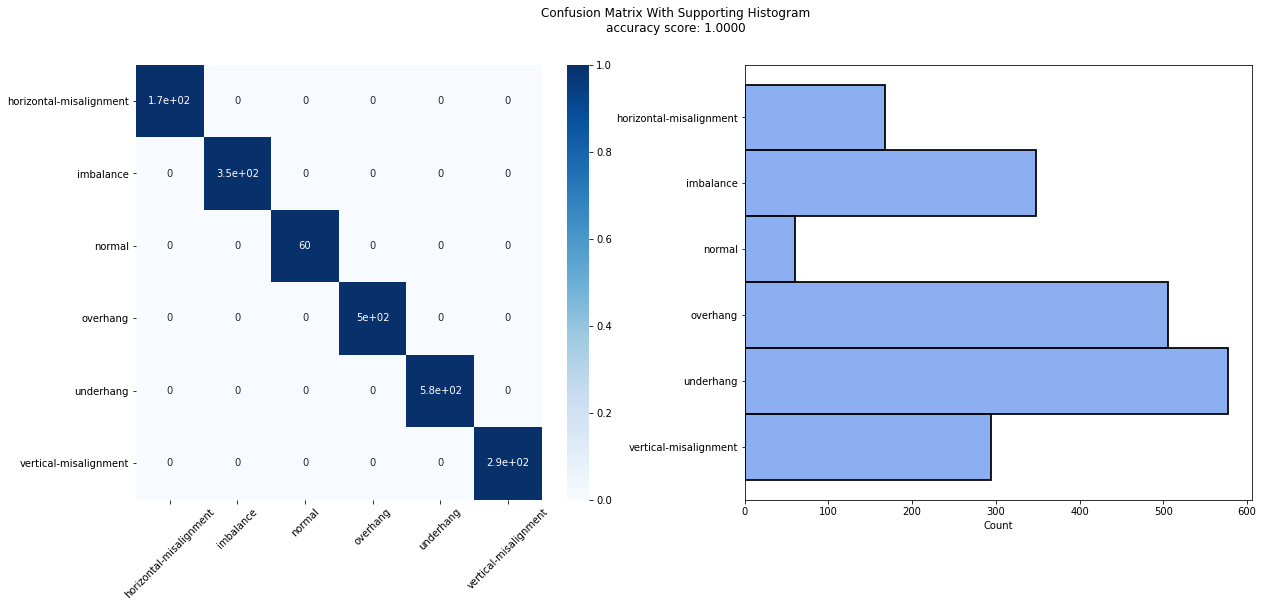

In [8]:
# used by the confusion_hist_plot function
target = 'class'

# load the model
model = joblib.load('./models/rfc_1sec.joblib')

# try to predict the data points we set aside for testing
preds = model.predict(X_test)

#plot our results
confusion_hist_plot(df=df,y_test=y_test,preds=preds,codes=classDict);

## "val_files" is a dataframe that will keep track of the following for the raw data files from the original summarized dataset:
    - source path
    - class
        - string representation
        - integer representation
    - index

In [9]:
val_files = df[['path','class','CLASS']].iloc[idxs]
val_files.head()
val_files.to_csv('./utils/test_files_1sec.csv')

In [10]:
val_files = pd.read_csv('./utils/test_files_1sec.csv').set_index('Unnamed: 0')

## Set up some variables that are important for summarizing raw data

In [6]:
# define each column as they are found in the raw data files
S = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']

# which statistical values we want to summarize from the raw data
Stats = ['-Entropy','-Kurtosis','-Mean','-F','-2F', '-3F'] # '-Std'

# which signals we want to apply the above statistics to. As per the paper, find the magnitude of the spectrum at
# F, 2F, and 3F for all signals other than the tachometer. That is why the tachometer is missing from this list.
Signals = ['axialUnderhang', 'axialOverhang','radialUnderhang',
          'radialOverhang','tangentialUnderhang','tangentialOverhang',
           'microphone']

# while we don't want the magnitude of the spectrum at F, 2F, and 3F for the tachometer, we DO want the other
# statistical features. So we add them here alongside the fundamental frequency and class label.
Others = ['tachometerSignal-Entropy','tachometerSignal-Kurtosis','tachometerSignal-Mean',
          #'tachometerSignal-Std','tachometerSignal-Min','tachometerSignal-Max',
          'fundamentalFrequency','class']

# create combinations of Signals and Stats to generate our feature names for summarization 
columns = [*itertools.product(Signals,Stats)]
for i,col in enumerate(columns):
    columns[i] = col[0]+col[1]
    
# add the other feature names to the final list of our columns
columns = columns + Others

## "utils" is a dictionary that keeps track of the following metadata:
    - the names of the columns from the raw data files (signals)
    - the names of teh columns used for feature extraction when summarizing raw data (columns)
    - a dictionary containing a mapping of fault names to integer values (classes)
    - a list of indices corresponding to individual raw data files from the original summarized dataset (idxs)

In [7]:
utils = {}
utils['signals'] = S
utils['columns'] = columns
utils['classes'] = classDict
# utils['idxs'] = idxs
with open('./utils/utils.json', 'w') as file:
    file.write(json.dumps(utils))

In [13]:
with open('./utils/utils_1sec.json', 'r') as file:
    utils = json.load(file)

# open an example config file and print it out to see the basic information contained in a config file

In [14]:
with open('./config/config.yaml','r') as stream:
    try:
        conf = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
conf

{'default': {'plot_path': '/Users/nrprzybyl/ML/MAFAULDA/window/plots/',
  'experiment_name': 'test1'},
 'sweep': {'random_pick': True,
  'n_files': 10,
  'file_idxs': [1396, 502, 1418, 990, 1420, 1823, 1408, 1296, 1402, 144],
  'width_per_step': {'lo': 2500, 'hi': 7500, 'step': 500},
  'window_width': {'lo': 10000, 'hi': 100000, 'step': 10000}}}

# using the template config file (above), modify values to your liking and quickly create new config files

In [15]:
# names = ['all_underhangs','all_overhangs','all_imbalance','all_vertical_misalignments','all_horizontal_misalignments','all_normals']
names = ['5sec']
classes = ['underhang','overhang','imbalance','vertical-misalignment','horizontal-misalignment','normal']
tag = 'rand'
for i,n in enumerate(names):
    conf['default']['experiment_name'] = f'{n}_{tag}'
    conf['default']['plot_path'] = '/ac-project/nprzybylski/window/plots/'
    conf['sweep']['random_pick'] = True
    conf['sweep']['n_files'] = 4
#     conf['sweep']['file_idxs'] = [*val_files[val_files['CLASS'] == classes[i]].index]
    conf['sweep']['width_per_step']['lo'] = 2500
    conf['sweep']['width_per_step']['hi'] = 2500
    conf['sweep']['window_width']['lo'] = 5000
    conf['sweep']['window_width']['hi'] = 250000
    conf['sweep']['window_width']['step'] = 5000
    
    with open(f'./config/{n}_{tag}.yaml', 'w') as f:
        yaml.dump(conf, f)

# define a list of directories to read output files from and collect accuracies from them
## collect accuracy data from these output files so we can see how widow width effects accuracy across random state transitions
    - note: Error messages come from some of the data being missing when running large experiments on AC with slurm.
            Still working on fix for jobs running to completion

In [16]:
# replace with your path to the "plots" directory
# found on the G-Drive in Machine Learning/Nick/MAFAULDA resources/resources/window/plots
path = f'{plot_path}/1sec_rand'
accs = []
for i in range(444):
    out = f'{path}_{i}/out'
    try:
        with open(out,'r') as file:
            outData = json.load(file)
        accs.append([outData[_]['acc'] for _ in outData])
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: './plots//1sec_rand_5/out'
[Errno 2] No such file or directory: './plots//1sec_rand_6/out'
[Errno 2] No such file or directory: './plots//1sec_rand_7/out'
[Errno 2] No such file or directory: './plots//1sec_rand_8/out'
[Errno 2] No such file or directory: './plots//1sec_rand_9/out'
[Errno 2] No such file or directory: './plots//1sec_rand_48/out'
[Errno 2] No such file or directory: './plots//1sec_rand_49/out'
[Errno 2] No such file or directory: './plots//1sec_rand_50/out'
[Errno 2] No such file or directory: './plots//1sec_rand_51/out'
[Errno 2] No such file or directory: './plots//1sec_rand_52/out'
[Errno 2] No such file or directory: './plots//1sec_rand_53/out'
[Errno 2] No such file or directory: './plots//1sec_rand_54/out'
[Errno 2] No such file or directory: './plots//1sec_rand_55/out'
[Errno 2] No such file or directory: './plots//1sec_rand_56/out'
[Errno 2] No such file or directory: './plots//1sec_rand_57/out'
[Errno 2] No such file or dire

In [17]:
_accs = []
for run in accs:
    # if all data points are present, keep accuracy values and put into new list
    if len(run) == 46:
        _accs.append(run)
        

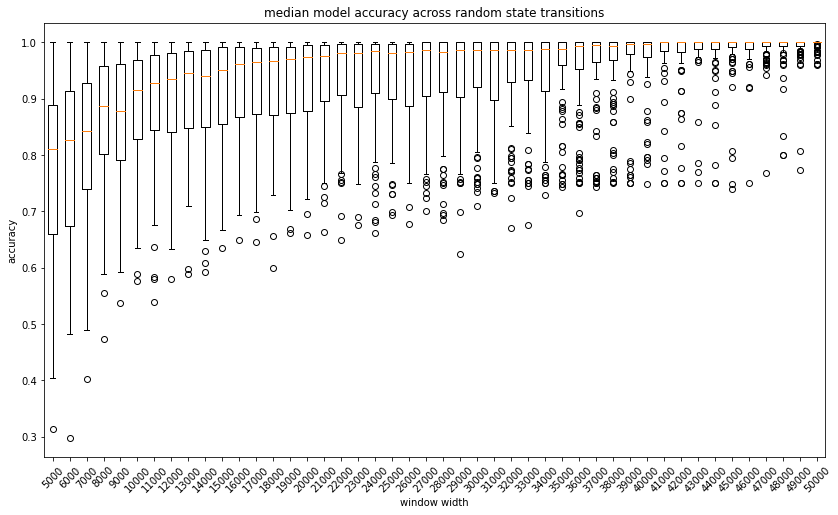

In [18]:
fig, ((ax1)) = plt.subplots(1,figsize=(14,8))
ax1.boxplot(np.array(_accs));
ax1.set_xticklabels(np.arange(5000,51000,1000),rotation=45);
ax1.set_xlabel('window width');
ax1.set_ylabel('accuracy');
ax1.set_title('median model accuracy across random state transitions');

# For each unique class, store accuracy/window width tuples so we could make plots similar to the one above on a class-to-class basis

In [19]:
zoneAccs = {}
for key in utils['classes']:
    if key != 'mixed':
        zoneAccs[key] = []

for run in outData:
    classes = [_[8] for _ in np.char.split(np.array(outData[run]['file_paths']),sep='/')]
    for i,zone in enumerate(outData[run]['zones']):
        zoneAccs[classes[i]].append((outData[run]['zones'][i]['acc'],int(run)))
    
zoneAccs

{'horizontal-misalignment': [],
 'imbalance': [(0.99, 5000),
  (0.98, 6000),
  (0.98, 7000),
  (0.97, 8000),
  (0.97, 9000),
  (0.97, 10000),
  (0.96, 11000),
  (0.96, 12000),
  (0.95, 13000),
  (0.95, 14000),
  (0.95, 15000),
  (0.94, 16000),
  (0.94, 17000),
  (0.93, 18000),
  (0.93, 19000),
  (0.93, 20000),
  (0.92, 21000),
  (0.92, 22000),
  (0.91, 23000),
  (0.91, 24000),
  (0.91, 25000),
  (0.9, 26000),
  (0.9, 27000),
  (0.89, 28000),
  (0.89, 29000),
  (0.89, 30000),
  (0.88, 31000),
  (0.88, 32000),
  (0.87, 33000),
  (0.87, 34000),
  (0.87, 35000),
  (0.86, 36000),
  (0.86, 37000),
  (0.85, 38000),
  (0.85, 39000),
  (0.85, 40000),
  (0.84, 41000),
  (0.84, 42000),
  (0.83, 43000),
  (0.83, 44000),
  (0.83, 45000),
  (0.82, 46000),
  (0.82, 47000),
  (0.81, 48000),
  (0.81, 49000),
  (0.81, 50000)],
 'normal': [],
 'overhang': [(0.77, 5000),
  (0.12, 5000),
  (0.6, 6000),
  (0.12, 6000),
  (0.91, 7000),
  (0.43, 7000),
  (0.89, 8000),
  (0.41, 8000),
  (0.84, 9000),
  (0.35, 

# collect accuracy data from out files for the following experiments:
    - 5000 to 250,000 (window width) using the model trained on all 5 seconds of data
    - 5000 to 250,000 (window width) using the model trained on 1 second slices of data
# so we can see how accuracy changes as a result of window width in both cases

In [3]:
dirs = ['all_normals','all_overhangs','all_vertical_misalignments','all_horizontal_misalignments','all_imbalance','all_underhangs']
labels = ['normal','overhang','vertical-misalignment','horizontal-misalignment','imbalance','underhang']

accs = []

for d in dirs:
    try:
        with open(f'{plot_path}/{d}_2500_250k_5sec/out','r') as file:
            # dictionary representation of out file
            t = json.load(file)
            # sort the dictionary
            for key in sorted(t):
                t[int(key.split('_')[0])] = t.pop(key)
            t = OrderedDict(sorted(t.items(), key=lambda t: t[0]))
            # pull out the information we need and store in a list
            accs.append([t[_]['acc'] for _ in t])
            
    except Exception as e:
        print(e)
        
accs_5sec = np.array(accs)

print(f'average accuracy across all zones for window width of 250,000 for 5sec model\n---------------------------------')
for i,a in enumerate(accs):
    print(f'{labels[i]}: {round(a[-1],4)}')
print(f'---------------------------------\naverage accuracy for all classes: {round(np.mean(accs_5sec[:,-1]),4)}')

average accuracy across all zones for window width of 250,000 for 5sec model
---------------------------------
normal: 0.3629
overhang: 0.936
vertical-misalignment: 0.9674
horizontal-misalignment: 0.7986
imbalance: 0.7887
underhang: 0.8572
---------------------------------
average accuracy for all classes: 0.7851


In [21]:
accs = []

for d in dirs:
    try:
        with open(f'{plot_path}/{d}_2500_250k_1sec/out','r') as file:
            t = json.load(file)
            for key in sorted(t):
                t[int(key.split('_')[0])] = t.pop(key)
            t = OrderedDict(sorted(t.items(), key=lambda t: t[0]))
            accs.append([t[_]['acc'] for _ in t])
            
    except Exception as e:
        print(e)
        
accs_1sec = np.array(accs)

print(f'average accuracy across all zones for window width of 50,000 for 1sec model\n---------------------------------')
for i,a in enumerate(accs_1sec):
    print(f'{labels[i]}: {round(a[9],4)}')
print(f'---------------------------------\naverage accuracy for all classes: {round(np.mean(accs_1sec[:,9]),4)}')

average accuracy across all zones for window width of 50,000 for 1sec model
---------------------------------
normal: 0.8998
overhang: 0.9928
vertical-misalignment: 0.9949
horizontal-misalignment: 0.9381
imbalance: 0.9623
underhang: 0.9637
---------------------------------
average accuracy for all classes: 0.9586


# plot out model accuracy as a result of window width
    - still messing with x-axis, would like it to read:
        - 1s, 2s, 3s, 4s, 5s

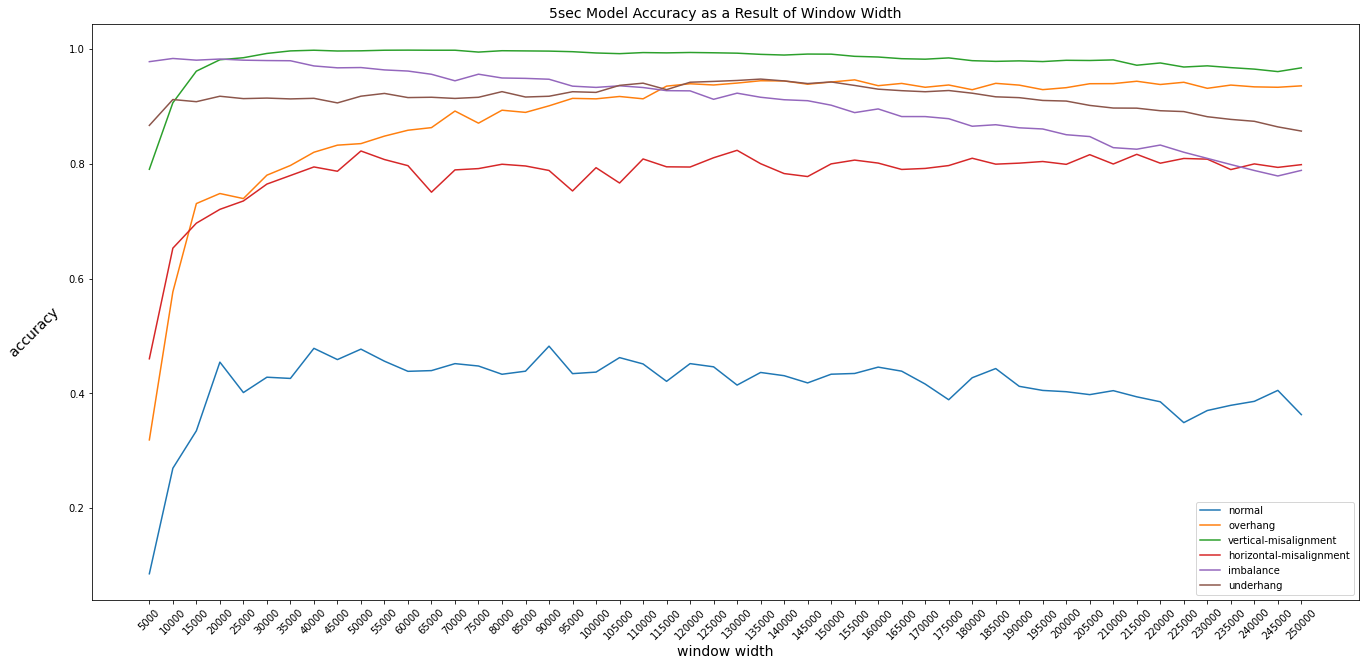

In [4]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
for i,a in enumerate(accs_5sec):
    ax.plot(a,label=labels[i])
plt.legend()
l=np.arange(5000,255000,5000)
ax.set_xticks(np.arange(len(l)))
ax.set_xticklabels(l,rotation=45)
plt.xlabel('window width',fontdict={'size':14})
plt.ylabel('accuracy                ',rotation=45,fontdict={'size':14})
plt.title('5sec Model Accuracy as a Result of Window Width',fontdict={'size':14});
# plt.locator_params(axis='x', nbins=5)

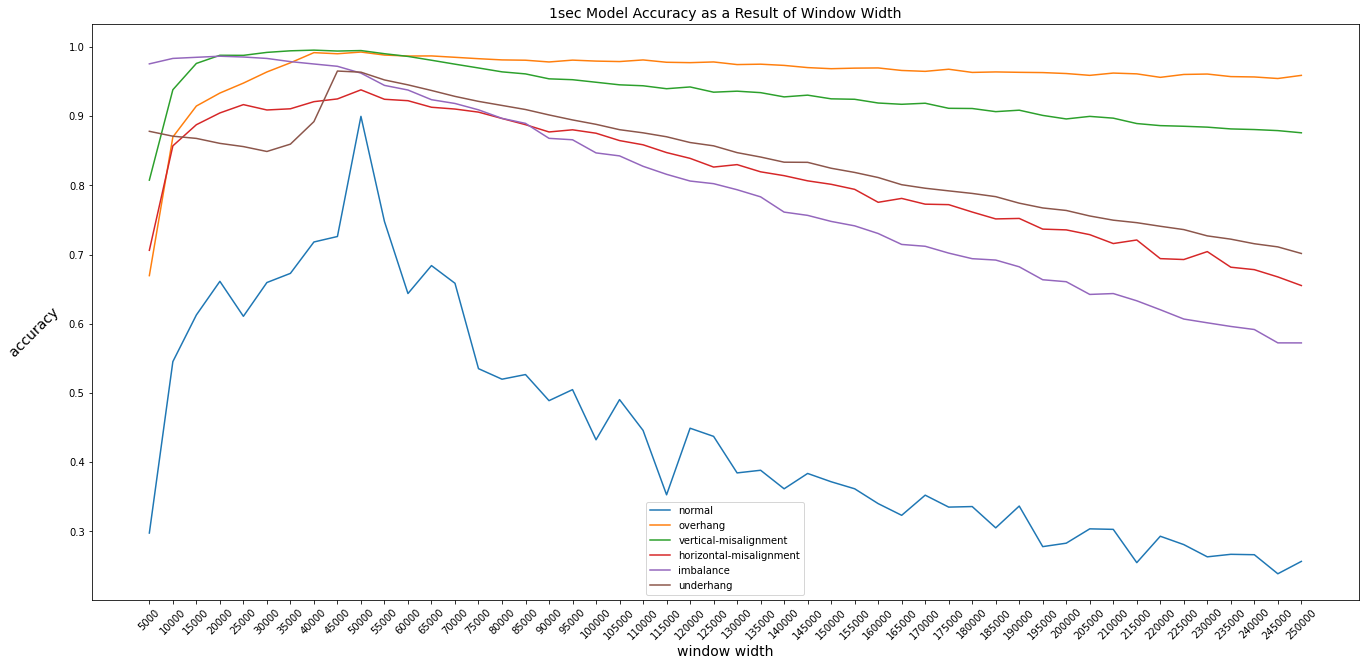

In [23]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
for i,a in enumerate(accs_1sec):
    ax.plot(a,label=labels[i])
plt.legend()
l=np.arange(5000,255000,5000)
ax.set_xticks(np.arange(len(l)))
ax.set_xticklabels(l,rotation=45)
plt.xlabel('window width',fontdict={'size':14})
plt.ylabel('accuracy                ',rotation=45,fontdict={'size':14})
plt.title('1sec Model Accuracy as a Result of Window Width',fontdict={'size':14});
# plt.locator_params(axis='x', nbins=5)

# brainstorming ideas for output

## Data to save after each run

        - accuracy
            - overall (maybe)
            - minus "mixed" areas (current)
            - per zone
            - per class (maybe save confusion matrix for this part)
            
        - metadata (by zone)
            - source file path
                - class
                - weight/misalignment/rpm/type of fault(ball, outer race, cage)

## Example output

In [27]:
from pprint import pprint
test1 = {   
    '1000_10000': {
        'overall_acc': 30,
        'acc': 35,
        'zones': {
            '1': { 'acc': 40, 'path': 'full/overhang/ball_fault/6g/12.6976.csv' },
            '2': { 'acc': 30, 'path': 'full/normal/12.288.csv' }
        }
    },
    '2000_10000': {
        'overall_acc': 40,
        'acc': 45,
        'zones': {
            '1': { 'acc': 50, 'path': 'full/overhang/ball_fault/6g/12.6976.csv' },
            '2': { 'acc': 40, 'path': 'full/normal/12.288.csv' }
        }
    }
}
pprint(test1)

{'1000_10000': {'acc': 35,
                'overall_acc': 30,
                'zones': {'1': {'acc': 40,
                                'path': 'full/overhang/ball_fault/6g/12.6976.csv'},
                          '2': {'acc': 30, 'path': 'full/normal/12.288.csv'}}},
 '2000_10000': {'acc': 45,
                'overall_acc': 40,
                'zones': {'1': {'acc': 50,
                                'path': 'full/overhang/ball_fault/6g/12.6976.csv'},
                          '2': {'acc': 40, 'path': 'full/normal/12.288.csv'}}}}
